In [35]:
"""
Introduction

This example demonstrates how to do structured data classification using TabTransformer, a deep tabular data modeling architecture for supervised and semi-supervised learning. The TabTransformer is built upon self-attention based Transformers. The Transformer layers transform the embeddings of categorical features into robust contextual embeddings to achieve higher predictive accuracy.

"""

'\nIntroduction\n\nThis example demonstrates how to do structured data classification using TabTransformer, a deep tabular data modeling architecture for supervised and semi-supervised learning. The TabTransformer is built upon self-attention based Transformers. The Transformer layers transform the embeddings of categorical features into robust contextual embeddings to achieve higher predictive accuracy.\n\n'

In [36]:
#we have installed TensorFlow Addons using the following command:

In [37]:
pip install -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [38]:
#Here we have imported the libraries that we will use

In [39]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [40]:
#preparin the data

In [41]:
"""
This example uses the United States Census Income Dataset provided by the UC Irvine Machine Learning Repository. The task is binary classification to predict whether a person is likely to be making over USD 50,000 a year.

The dataset includes 48,842 instances with 14 input features: 5 numerical features and 9 categorical features.

"""


'\nThis example uses the United States Census Income Dataset provided by the UC Irvine Machine Learning Repository. The task is binary classification to predict whether a person is likely to be making over USD 50,000 a year.\n\nThe dataset includes 48,842 instances with 14 input features: 5 numerical features and 9 categorical features.\n\n'

In [42]:
#First, let's load the dataset from the UCI Machine Learning Repository into a Pandas DataFrame:

In [43]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=CSV_HEADER)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [46]:
#Here we have removed the first record because it is not a valid data example also we have removed a trailing 'dot' in the class labels.

In [47]:
test_data = test_data[1:]
test_data.income_bracket = test_data.income_bracket.apply(
    lambda value: value.replace(".", "")
)

In [48]:
#Now we store the training and test data in separate CSV files.

In [49]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [50]:
#Define dataset metadata

In [51]:
""" 
This is where we define metadata for our dataset. It helps read and analyze the data of the input features and encode the input features by type.
"""

' \nThis is where we define metadata for our dataset. It helps read and analyze the data of the input features and encode the input features by type.\n'

In [52]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "age",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "workclass": sorted(list(train_data["workclass"].unique())),
    "education": sorted(list(train_data["education"].unique())),
    "marital_status": sorted(list(train_data["marital_status"].unique())),
    "occupation": sorted(list(train_data["occupation"].unique())),
    "relationship": sorted(list(train_data["relationship"].unique())),
    "race": sorted(list(train_data["race"].unique())),
    "gender": sorted(list(train_data["gender"].unique())),
    "native_country": sorted(list(train_data["native_country"].unique())),
}
# Name of the column to be used as instances weight.
WEIGHT_COLUMN_NAME = "fnlwgt"
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "income_bracket"
# A list of the labels of the target features.
TARGET_LABELS = [" <=50K", " >50K"]

In [53]:
#Configure the hyperparameters

In [54]:
"""
The hyperparameters includes model architecture and training configurations.
"""

'\nThe hyperparameters includes model architecture and training configurations.\n'

In [55]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 15

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

In [56]:
#Implement data reading pipeline

In [57]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    weights = features.pop(WEIGHT_COLUMN_NAME)
    return features, target_index, weights


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()

C:\Users\salma\anaconda3\envs\tf\lib\site-packages\numpy\core\numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [58]:
"""
define an input function that reads the file, parses it, and transforms the features and labels of the atf.data.Dataset for training or evaluation.
"""

'\ndefine an input function that reads the file, parses it, and transforms the features and labels of the atf.data.Dataset for training or evaluation.\n'

In [59]:
#Implement a training and evaluation procedure

In [60]:
def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history

In [61]:
#Create model inputs

In [62]:
"""
Here we define the inputs for the models as a dictionary, where the key is the feature name, and the value is a keras.layers.Input tensor with the corresponding feature shape and data type.
"""

'\nHere we define the inputs for the models as a dictionary, where the key is the feature name, and the value is a keras.layers.Input tensor with the corresponding feature shape and data type.\n'

In [63]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [64]:
#Encode features

In [65]:
"""
The encode_inputs method returns encoded_categorical_feature_list and numerical_feature_list. We encode the categorical features as embeddings, using a fixed embedding_dims for all the features, regardless their vocabulary sizes. This is required for the Transformer model.
"""

'\nThe encode_inputs method returns encoded_categorical_feature_list and numerical_feature_list. We encode the categorical features as embeddings, using a fixed embedding_dims for all the features, regardless their vocabulary sizes. This is required for the Transformer model.\n'

In [66]:
def encode_inputs(inputs, embedding_dims):

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list


In [67]:
#Implement an MLP block

In [68]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

In [69]:
#Experiment 1: a baseline model

In [70]:
"""
In this experiment, we create a simple multi-layer feed-forward network.

"""

'\nIn this experiment, we create a simple multi-layer feed-forward network.\n\n'

Total model weights: 109629


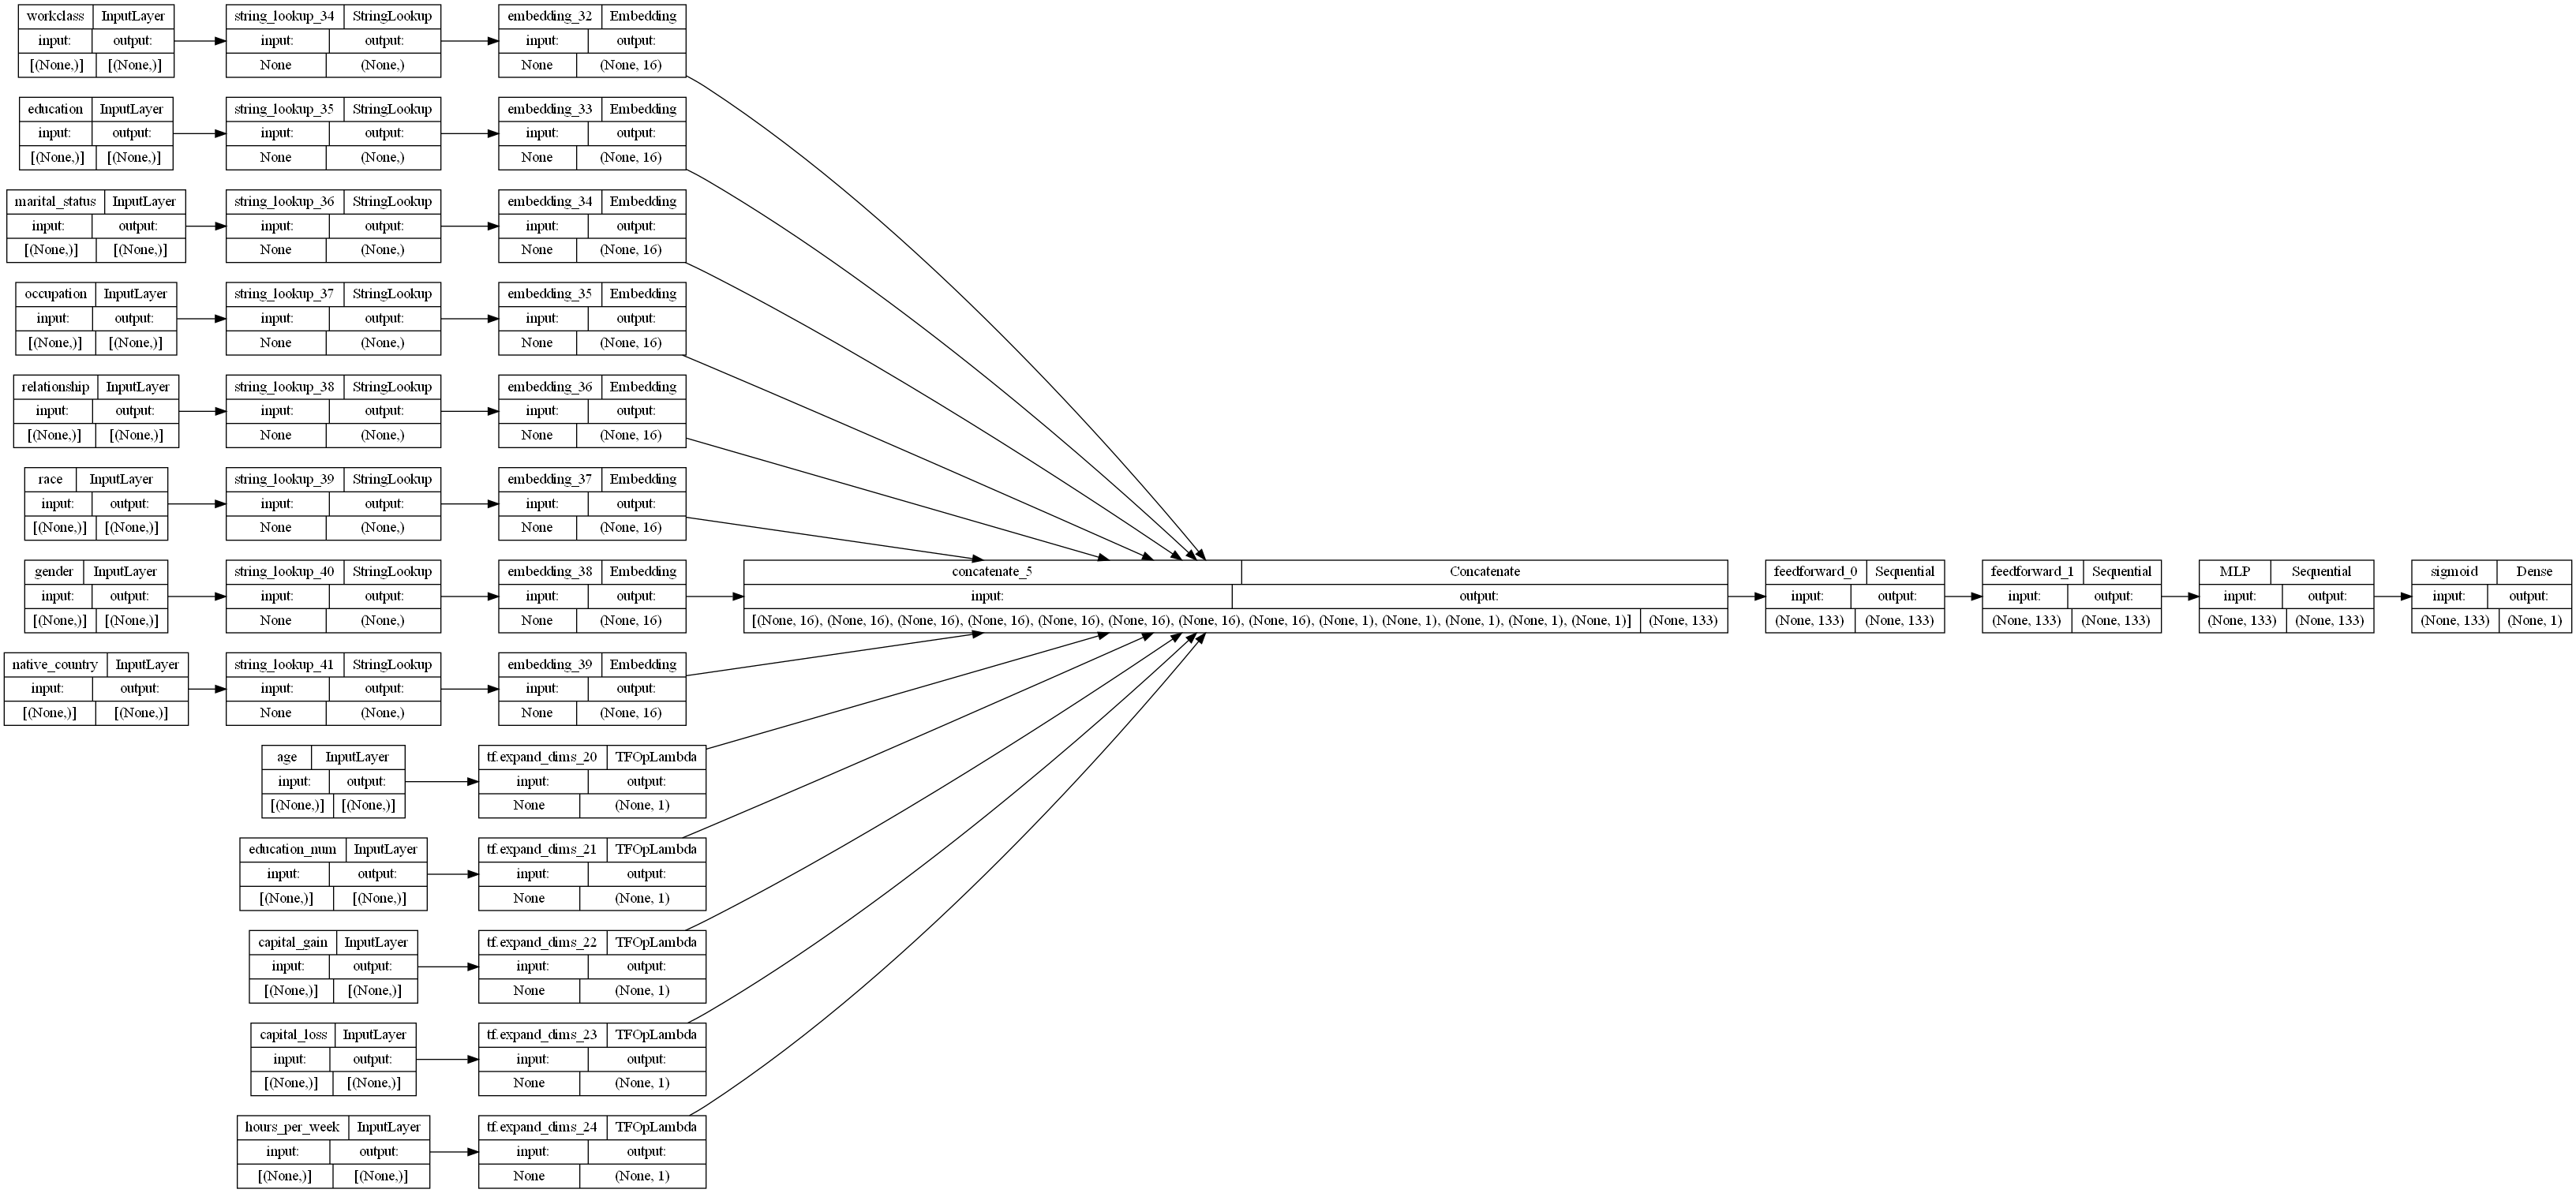

In [71]:
def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

In [72]:
#Let's train and evaluate the baseline model:

In [73]:
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
    122/Unknown - 6s 17ms/step - loss: 111117.2266 - accuracy: 0.7486WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.
123/123 [==============================] - 8s 27ms/step - loss: 111100.6250 - accuracy: 0.7487 - val_loss: 94077.1328 - val_accuracy: 0.7812
Epoch 2/15
123/123 [==============================] - 2s 17ms/step - loss: 92773.3984 - accuracy: 0.7682 - val_loss: 71810.0312 - val_accuracy: 0.8084
Epoch 3/15
123/123 [==============================] - 2s 16ms/step - loss: 76687.4531 - accuracy: 0.7926 - val_loss: 68173.4844 - val_accuracy: 0.8143
Epoch 4/15
123/123 [==============================] - 2s 16ms/step - loss: 72986.7734 - accuracy: 0.8010 - val_loss: 67794.5469 - val_accuracy: 0.8274
Epoch 5/15

Validation accuracy: 83.91%


In [74]:
# conclusion of the first expirement : The baseline linear model achieves ~81% validation accuracy.

In [75]:
#Experiment 2: TabTransformer

In [76]:
"""
The TabTransformer architecture works as follows:

1- All the categorical features are encoded as embeddings, using the same embedding_dims. This means that each value in each categorical feature will have its own embedding vector.
2- A column embedding, one embedding vector for each categorical feature, is added (point-wise) to the categorical feature embedding.
3- The embedded categorical features are fed into a stack of Transformer blocks. Each Transformer block consists of a multi-head self-attention layer followed by a feed-forward layer.
4- The outputs of the final Transformer layer, which are the contextual embeddings of the categorical features, are concatenated with the input numerical features, and fed into a final MLP block.
5- A softmax classifer is applied at the end of the model.
"""

'\nThe TabTransformer architecture works as follows:\n\n1- All the categorical features are encoded as embeddings, using the same embedding_dims. This means that each value in each categorical feature will have its own embedding vector.\n2- A column embedding, one embedding vector for each categorical feature, is added (point-wise) to the categorical feature embedding.\n3- The embedded categorical features are fed into a stack of Transformer blocks. Each Transformer block consists of a multi-head self-attention layer followed by a feed-forward layer.\n4- The outputs of the final Transformer layer, which are the contextual embeddings of the categorical features, are concatenated with the input numerical features, and fed into a final MLP block.\n5- A softmax classifer is applied at the end of the model.\n'

Total model weights: 87479


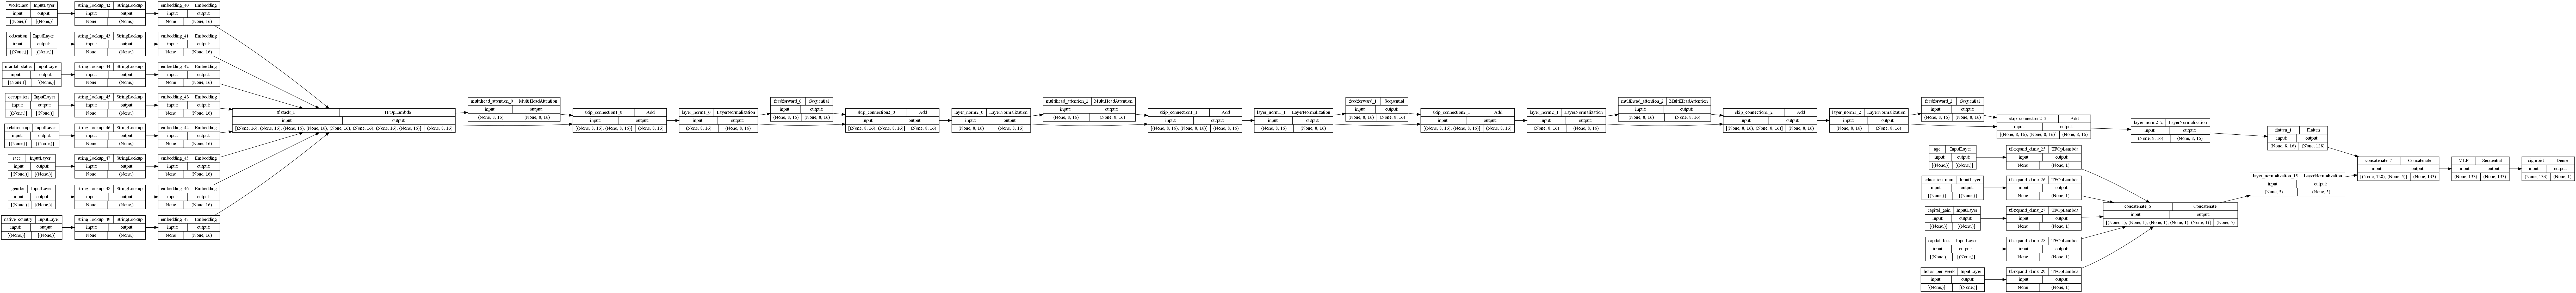

In [77]:
def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

In [78]:
#Let's train and evaluate the TabTransformer model:

In [79]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
    123/Unknown - 17s 71ms/step - loss: 82189.2500 - accuracy: 0.7977WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.
123/123 [==============================] - 20s 94ms/step - loss: 82189.2500 - accuracy: 0.7977 - val_loss: 66823.0625 - val_accuracy: 0.8299
Epoch 2/15
123/123 [==============================] - 11s 90ms/step - loss: 69493.2422 - accuracy: 0.8249 - val_loss: 66634.9922 - val_accuracy: 0.8264
Epoch 3/15
123/123 [==============================] - 12s 97ms/step - loss: 66828.6328 - accuracy: 0.8316 - val_loss: 63980.9844 - val_accuracy: 0.8314
Epoch 4/15
123/123 [==============================] - 11s 91ms/step - loss: 65317.6211 - accuracy: 0.8360 - val_loss: 61274.6992 - val_accuracy: 0.8454
Epoch 5

Validation accuracy: 84.5%


In [80]:
"""
TabTransformer models achieve up to 85% validation accuracy. Note that with the default parameter configuration, the number of trainable weights for Baseline and TabTransformer are 109,629 and 92,151, respectively, and both use the same training hyperparameters.
"""

'\nTabTransformer models achieve up to 85% validation accuracy. Note that with the default parameter configuration, the number of trainable weights for Baseline and TabTransformer are 109,629 and 92,151, respectively, and both use the same training hyperparameters.\n'